# MoA (Mechanisms of Action)

So in this notebook, I just want to get an overview of the data, how the variables are distributed, what do we have to predict, and maybe come up with a few feature ideas. Since I have little knowledge on the subject, most of the feature ideas would be based on data distribution and not on domain knowledge. 

I also want this notebook to be a basic pipeline of sorts, so that one can always come back and work on just improving the models. So let's start with some libraries.

In [ ]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px


Let's load in only the features for now, and later we'll load in the target labels.

In [ ]:
train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

# EDA Overview

In [ ]:
print("There are {} features and {} rows in the train data.".format(train.shape[1], train.shape[0]))
print("There are {} features and {} rows in the test data.".format(test.shape[1], test.shape[0]))

In [ ]:
train.head()

Let's look at a summary of our data: how many float columns and object columns are there?

In [ ]:
print(train.info())
print()
print(test.info())

So basically all features are float features, and there may not be any interesting encoding that could be done. We will try out a few later. Looking at the data, we have almost 900 float columns, so let's see how different they really are. Now, we can't make a plot for comparing them, since there are too many, but let's look at the mean and median for about 10 of them.

In [ ]:
train.describe()

So they are very very similar in terms of their ranges, indicating that they may be similar in nature. There might be a fixed scale along which all of these features are measured, due to which they have a similar median and min-max range. Let's see if it is the same for test.

In [ ]:
test.describe()

Again they look very similar. Another thing is that the ranges look like they are the same in train and test data, so that's definitely going to help when modelling. We won't have to take into account feature shifts, etc, but let's see what new insight may come later.

Let's start with the two categorical variables.

In [ ]:
a = train['cp_type'].value_counts().reset_index()
fig = px.pie(a, values='cp_type', names='index', title='CP Type')
fig.show()

a = train['cp_dose'].value_counts().reset_index()
fig = px.pie(a, values='cp_dose', names='index', title='CP Dose')
fig.show()


The graphs clearly show us that more sample (I think, correct me if I am wrong) were treated with a compound, rather than a control Perturbation. This is good, because control perturbations don't have MoAs, so it could be more complicated to train on them.

Secondly, it looks like roughly half the patients have had a high dose, and the other half have had a low dose. This shows a good equal representation in the dataset, so we may not have to worry too much about imbalances. Let's make sure the distribution is the same in test data as well.

In [ ]:
a = test['cp_type'].value_counts().reset_index()
a['Percentage'] = a['cp_type'] / len(test)


b = test['cp_dose'].value_counts().reset_index()
b['Percentage'] = b['cp_dose'] / len(test)

a

In [ ]:
b

Again, the test data is on our side, and has a similar percentage distribution as the training data. This is again great for our model.

Let's move onto the dosage timing, since this is the last variable which is not anonymous.

In [ ]:
a = train.groupby('cp_time').count()


fig = px.bar(a, x=['24', '48', '72'], y='sig_id')
fig.show()

a = test.groupby('cp_time').count()


fig = px.bar(a, x=['24', '48', '72'], y='sig_id')
fig.show()

Again, here it looks like there isn't one specific dosage timing that has been popularly used. Also, the train and test data are similar in distribution. One important thing about this feature is that it is fundamentally a categorical variable, but has a numerical value. Hence, we should probably label encode (or one-hot encode it) instead of leaving it as a continuous variable. (This step doesn't matter when using tree based models, only linear models).

In [ ]:
a = train.groupby('cp_dose').max()
a

A couple of things I wanted to mention here. I did do some more analysis on the relation between the features above, and just wanted to mention it instead of making plots for it cause it isn't value additive:

- CP_Type and CP_Time are completely independent (meaning that different treatment types don't have a significantly different dosage duration).
- CP_Dose and CP_Time are also completely indpendent (its not that high dosage has a significantly higher or lower average treatment duration).
- CP_Type and CP_Dose are also indpendent (its not that a particular treatment type has a higher or lower average dosage.


All in all, from the features above, the dataset seems to be very homogenous. No imbalances whatsoever. It's almost as if every treatment picked the values of the first few columns at random, creating a sort of random experiment (maybe to try out all possible treatment combinations of a drug?). This removes any value addition from features which combine the features discussed above.

Now let's move onto the majority of the features. Right now, I am only going to plot two of each, because there are almost hundreds of them.

In [ ]:
import plotly.figure_factory as ff

# Add histogram data
x1 = train['g-0']
x2 = train['g-10']
x3 = test['g-0']
x4 = test['g-10']

# Group data together
hist_data = [x1, x2, x3, x4]

group_labels = ['Train G-0', 'Train G-10', 'Test G-0', 'Test G-10']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

This histogram gives us some more insight into the G features. It appears that they all look like they have a normal distribution, and there is a small shift in the mean. But the main dividing element is the skewness. From the tick marks shown below the histogram, we can see that the red variable looks like it has a slight positive skew (towards the left), and the green looks like a slight negative skew.

Even with the orange has a positive skew, but the blue has a negative skew. Based on this, maybe a feature could be made on how far away a data point is from the mean, taking into account the skewness of each chart. Since z-score directly won't be very helpful, we could empirically find the number of data points below the row of interest (by merging train and test, and then finding the number of data points less than this value).

In [ ]:

# Add histogram data
x1 = train['c-0']
x2 = train['c-10']
x3 = test['c-0']
x4 = test['c-10']

# Group data together
hist_data = [x1, x2, x3, x4]

group_labels = ['Train C-0', 'Train C-10', 'Test C-0', 'Test C-10']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

These features are much more interesting. They have very clear fat tails here, and all of them surprisingly are towards -10. Given this, I might expect the data points in the hump towards the left to have slightly different properties, so a feature could be whetehr it is in this hump or not. But this feature will be less useful for now because only a handful of datapoints (in percentage) are actually in this range.

Again, a potential empirical z-score could be applied to make features.

# TSNE

Before we move onto target features, lets just use TSNE to find out how the data is sort of distributed by dimensionality reduction.
For this I will be using Rapids, as it is really fast compared to sklearn.

In [ ]:
import sys
!cp ../input/rapids/rapids.0.15.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/


In [ ]:
import cuml, cudf
from cuml.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

colsToDrop = ['sig_id', 'cp_time', 'cp_type', 'cp_dose']
tsneData = train.drop(colsToDrop, axis=1)


tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(tsneData)

plt.scatter(train_2D[:,0], train_2D[:,1], s = 0.5)
plt.title("Compressed Training Data")
plt.show()

Okay, so this TSNE plot will actually change every time I run it, but the general outline stays the same (sometimes it just ends up as one blob in the corner). I am not using plotly here as it makes the notebook lag. So here's a picture of what I am seeing:
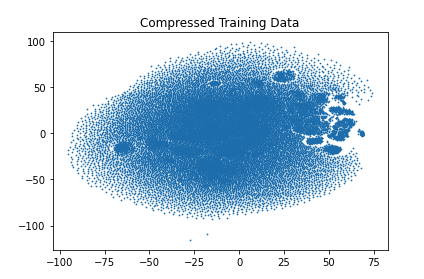

It looks like a majority data is clustered into different groups (you can even see groups in the center, but they are less clear). Then, there are a bunch of data points that are just evenly scattered across the plot. So it looks like about more than half of the data points are structured and have a cluster, and the rest are sort of evenly distributed. This is interesting, as it gives hope that an ML model may be able to predict the targets accurately, but we will have to see.

Let's see for test data

In [ ]:

colsToDrop = ['sig_id', 'cp_time', 'cp_type', 'cp_dose']
tsneData = test.drop(colsToDrop, axis=1)


tsne = TSNE(n_components=2)
test_2D = tsne.fit_transform(tsneData)

plt.scatter(test_2D[:,0], test_2D[:,1], s = 0.5)
plt.title("Compressed Test Data")
plt.show()

So this data also has one or two clear clusters. The rest is not very clear, but it may be because of the low amount of data, so it is hard for us to see structure.

# Target Labels

Now let's move onto target variables.

In [ ]:
train_target = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')

In [ ]:
print("Target data has {} prediction variables".format(train_target.shape[1] - 1))

In [ ]:
train_target.head()

Wow, that's a lot of 0s. Let's see if there is a class imbalance problem here.

In [ ]:
train_target.describe()

Man, looks like we have a huge class imbalance problem. Well, the features behaved too nicely, so the catch had to be here. 
We can see that the mean is very close to 0 for most variables, and for all it looks like it is closer to 0 than 1. Also, the first, second and third quartile values are all 0, showing that more than 75% of the data has 0 as a target. This may make it especially hard to train a NN.

This dataset is not easy to do data augmentation with either (in fact, I don't even know if that's possible). The only way to get more positives would be to search for external data. I guess this shows us how hard drug discovery is, and how patient one has to be to get results.

Let's also just plot the distribution curve for one targe (doesn't matter much, just to see class imbalance).

In [ ]:
a = train_target['acat_inhibitor'].value_counts().reset_index()
fig = px.pie(a, values='acat_inhibitor', names='index', title='acat_inhibitor')
fig.show()

So this just tells us an even more pessimistic story. Only 0.1% of the data is positive. Rest is all negative results. This really may make model training hard, so I think we are going to have to develop some ingenious way for predictions.

One more interesting thing is that the Metric for this competition is based on Log-Loss. But with class imbalances, I would expect there to be another metric like AUC as they are not as susceptible to class imbalances. For comparision, in this competition, submitting all 0.5 (sample submission) gets a score of 0.69314. I created a submission of only 0s as predictions, and that got a score of 0.13073. There is a huge difference in these scores even though both are equally unintelligent, which is why Log-Loss is not used in class imbalance. Anyway, let's move on now since the metric is fixed.


Since there are too many 0s for doing a meaningful TSNE for target labels, let's move onto modelling stage.

# Modeling

In [ ]:
train.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

objCols = ['cp_type', 'cp_time', 'cp_dose']
for col in objCols:
    le.fit(train[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    
train.head()

## Extra Trees Classifier

So I have already submitted this model and it scores 0.11932 on the public leaderboard. There might be some variations in the score since this is a extremely random forest model. Also, I have used only 100 estimators to keep the time under 5 mins, but using more would probably give a better result. Same with teh max_depth. Increasing it would help but would take a lot more time.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

rf = ExtraTreesClassifier(n_estimators=100, criterion="entropy", max_depth = 15, max_features = "sqrt", random_state = 1, bootstrap=True, max_samples = 1000, n_jobs=-1)

In [ ]:
rf.fit(train.drop(['sig_id'], axis=1), train_target.drop(['sig_id'], axis=1))

In [ ]:
preds = rf.predict(test.drop(['sig_id'], axis=1))
preds.shape

In [ ]:
sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

for i in range(len(sub.columns)):
    if i != 0:
        col = sub.columns[i]
        sub[col] = preds[:, i - 1]
sub

In [ ]:
sub.to_csv('submissionExtraTrees.csv', index=False)

## K Nearest Neighbors

With 800 features and 38000 rows, it may be mad to use KNN! But rapids is surprisingly fast, in fact, the rapids KNN took less time for running than the Extra Trees Regressor Model! I think this could be a good baseline approach since the competition says "One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithm that search for similarity to known patterns in large genomic databases". The training data could act as our database (and later down the line, we can add external data), and KNN is fundamentally a similarity based algorithm. I have already submitted this algorithm, and it scores 0.11351, which is better than the Extra Trees Algorithm.

I won't be normalizing or scaling any features since they are already in a very similar range.

In [ ]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(train.drop(['sig_id'], axis=1), train_target.drop(['sig_id'], axis=1))

In [ ]:
preds = knn.predict(test.drop(['sig_id'], axis=1))

In [ ]:
sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

for i in range(len(sub.columns)):
    if i != 0:
        col = sub.columns[i]
        sub[col] = preds[:, i - 1]
sub

In [ ]:
sub.to_csv('submissionKNN.csv', index=False)

## Neural Network

Here, I will be trying a simple 3 layer Neural Network (excluding Input Layer). Right now, the Number of neurons is quite arbritary and could be tuned to increase performance. I just tried to slowly decrease the number of neurons from 875 input dimension to 200 output neurons. I have also added a small amount of dropout. I tried out a few values and I think the numbers should be somewhere in this ballpark, but can be tuned further. For epochs, I plotted the training curves for about 50 epochs locally and chose where I think the NN started overfitting on average. I will be using Keras for implementation, and a 5 K-Fold validation system (since all features look roughly evenly distributed in train and test.

Note that the Neural Network can be made much better by making it bigger or tuning parameters.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

print("Tensorflow Version: " + tf.__version__)

In [ ]:
def create_model(show_summary = True):
    X_input = Input((875,))
    X = Dropout(0.075)(X_input)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = Dense(2056, activation='relu')(X)
    X = Dropout(0.3)(X)
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(600, activation='relu')(X)
    X = Dropout(0.05)(X)
    X = Dense(400, activation='relu')(X)
    X = Dropout(0.01)(X_input)
    X = Dense(206, activation='sigmoid')(X)    #We need sigmoid not Softmax because labels are mostly independent of each other.
    
    model = Model(inputs = X_input, outputs = X)
    opt = Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['AUC'])   #Closest default loss function (to competition metric) is logloss or categorical cross entropy. I will also be using AUC just as a side metric for supervision, but shouldn't be taken very seriously.
    if show_summary:
        model.summary()
    return model

In [ ]:
model = create_model()

In [ ]:
nFolds = 5

kf = KFold(n_splits = nFolds)
trd = train.drop(['sig_id'], axis=1).values
targetd = train_target.drop(['sig_id'], axis=1).values
testd = test.drop(['sig_id'], axis=1).values

preds = np.zeros((3982, 206))

fold = 1
for train_index, test_index in kf.split(trd):
    
    print("Fold  " + str(fold))
    fold += 1
    
    x_train, x_test = trd[train_index], trd[test_index]
    y_train, y_test = targetd[train_index], targetd[test_index]

    model = create_model(False)
    history = 0
    history = model.fit(x_train, y_train, batch_size = 32, epochs=65, shuffle = True, validation_data = (x_test, y_test), verbose=0)
    
    fig = plt.figure(figsize=(9, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    foldPred = model.predict(testd)
    preds += foldPred / nFolds

In [ ]:
preds

In [ ]:
sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

for i in range(len(sub.columns)):
    if i != 0:
        col = sub.columns[i]
        sub[col] = preds[:, i - 1]
sub

In [ ]:
sub.to_csv('submission.csv', index = False)




# Conclusion:

So we have the following conclusions:

- Training and Testing data seem to have a similar distribution (atleast generally). Even adversarial validation shows this.
- The non g and c features are independent of each other and there seems to be no clear relationship.
- Huge Class Imbalance Problem - Surprisingly using log-loss as a metric.
- Models that don't require extensive feature engineering may work better for this dataset.

I will continue to add more in this notebook. Thanks a lot for reading all the way to the end. Please upvote if you found it helpful.